# Лабораторное задание для модуля "Классификация"

Задача этого занятия - разработать модель, предсказывающую класс SMS-сообщения: "спам" или "не-спам"

На этом занятии мы получим исходный датасет, посмотрим данные, проведём небольшую предобработку, а затем попробуем применить к ним самописную модель K-ближайших соседей

# Датасет

В качестве исходных данных предлагается использовать датасет, собранный командой Центра машинного обучения и интеллектуальных систем Калифорнийского университета. 

Создатели датасета разрешают использовать его, оставляя при этом ссылку на их сайт (где подробно описана структура данных) и публикацию:

> https://www.dt.fee.unicamp.br/~tiago/smsspamcollection/

> Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.


Датасет поставляется вместе с этим ноутбуком. Также его можно скачать по ссылке ниже:
> http://archive.ics.uci.edu/ml/machine-learning-databases/00228/

## Получение исходных данных
Если запуск происходит в GoogleColab, то нужно будет примонтировать GoogleDrive в интерактивном режиме

In [1]:
# определение запуска в Colab по косвенным признакам
__folder_list = !ls
__working_dir = !pwd
colab_driven = True if 'sample_data' in __folder_list[0] and '/content' in __working_dir else False

if colab_driven and not 'drive' in __folder_list[0]: # если в Колабе и ещё не подключили Гугл-диск с данными
    from google.colab import drive
    drive.mount('/content/drive') # тут надо интерактивно ввести ключ авторизации

del __folder_list, __working_dir


Если путь к данным отличается, Вам нужно его исправить на свой:

In [2]:
path_to_data = 'drive/MyDrive/ИИ для ИБ/spam.csv' if colab_driven else 'spam.csv'

Импортируем библиотеки, которые нам пригодятся в ближайшее время

In [3]:
import numpy as np # линейная алгебра
import pandas as pd # обработка данных, запись и чтение CSV (в том числе - pd.read_csv)

Прочитаем даннне в Dataframe

In [4]:
# ISO-8859-1 - однобайтовая кодировка для UTF-8
df = pd.read_csv(path_to_data, encoding = 'ISO-8859-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


# Предобработка данных

## Оценка данных

Посмотрим, сколько данных у нас имеется

In [5]:
df.shape

(5572, 5)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


## Удаление пустых ячеек

Оценим количество пустых ячеек

In [7]:
df.isnull().sum()

v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64

Столбцы с большим количеством пропусков удалим

In [8]:
df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1, inplace=True)

In [9]:
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Посмотрим, сколько в датасете экземпляров каждого класса

In [10]:
df.v1.value_counts(dropna=False)

ham     4825
spam     747
Name: v1, dtype: int64

## Создание признаков

В качестве исходных данных остался текст сообщения. Много это или мало? Достаточно. Но попробуем добавить ещё данных, по которым можно будет отделить обычные сообщения от рекламных - например, посмотрим, как распределена длина текстовых сообщений в каждой категории

In [11]:
df['length'] = df['v2'].apply(len)

In [12]:
df.head(3)

,v1,v2,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155


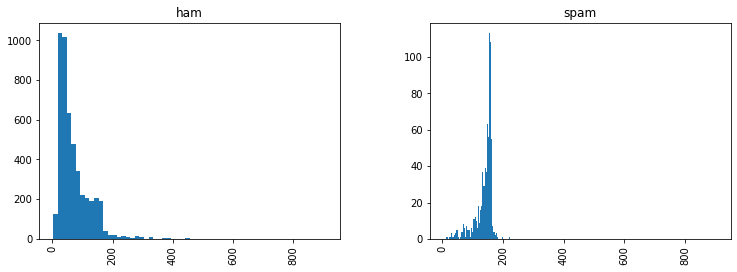

In [13]:
import matplotlib.pyplot as plt # модуль для отображения графиков
df.hist(column='length',by='v1',bins=60,figsize=(12,4)); # генерация гистограммы
plt.xlim(-40,950); # ограничение гистограммы (чтобы оба графика были в одинаковом масштабе)

Видно, что, хоть длина и не является разделяющим признаком, полезную информацию из неё можно получить.

## Кодировка названий в one-hot

Для удообства использования модели в будущем заменим текстовые названия классов на числа в виде унитарного кода. Его особенность в том, что в числе содержится всего одна единица, расположение которой определяет класс объекта

In [14]:
y = pd.get_dummies(df['v1'], drop_first = True) # определим класс для каждого сэмпла

In [15]:
y.head(3)

,spam
0,0
1,0
2,1


In [16]:
df = pd.concat([df, y], axis=1) # добавим новый столбец к существующим

In [17]:
df.head(3)

,v1,v2,length,spam
0,ham,"Go until jurong point, crazy.. Available only ...",111,0
1,ham,Ok lar... Joking wif u oni...,29,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,1


In [18]:
df.drop('v1', axis=1, inplace=True) # и удалим лишний теперь столбец с оригинальными названиями

In [19]:
df.head(3)

,v2,length,spam
0,"Go until jurong point, crazy.. Available only ...",111,0
1,Ok lar... Joking wif u oni...,29,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,155,1


## Очистка текстовых данных

Текст содержит много информации, которая будет только мешать классификации. Почистим его. Чтобы разобраться, как это делается, используем регулярные выражения, с помощью которых удалим некоторые лишние знаки, такие как:
*   адреса электронной почты
*   веб-адреса
*   числа
*   символы, обозначающие валюту
*   знаки пунктуации


Исходный текст (до обработки)

In [20]:
print(df.v2)

0       Go until jurong point, crazy.. Available only ...
1                           Ok lar... Joking wif u oni...
2       Free entry in 2 a wkly comp to win FA Cup fina...
3       U dun say so early hor... U c already then say...
4       Nah I don't think he goes to usf, he lives aro...
                              ...                        
5567    This is the 2nd time we have tried 2 contact u...
5568                Will Ì_ b going to esplanade fr home?
5569    Pity, * was in mood for that. So...any other s...
5570    The guy did some bitching but I acted like i'd...
5571                           Rofl. Its true to its name
Name: v2, Length: 5572, dtype: object


In [21]:
# Замена адреса электронной почты на слово 'email'
processed = df.v2.str.replace(r'^.+@[^\.].*\.[a-z]{2,}$', 'email')

# Замена веб-адресов на слово 'webaddress'
processed = processed.str.replace(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$', 'webaddress')

# Замена символов валюты на слово 'moneysymb' (Символ "£" можно набрать с помощью Alt и кода 0163)
processed = processed.str.replace(r'£|\$', 'moneysymb')
    
# Замена 10-значных номеров телефонов на слово 'phonenumber' (с учётом спецсимволов)
processed = processed.str.replace(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$', 'phonenumbr')
    
# Замена остальных чисел на слово 'numbr'
processed = processed.str.replace(r'\d+(\.\d+)?', 'numbr')

# Удаление знаков пунктуации
processed = processed.str.replace(r'[^\w\d\s]', ' ')

# Удаление лишних пробелов (замена нескольких идёщих подряд пробелов на один)
processed = processed.str.replace(r'\s+', ' ')

# Удаление пробелов в начале и в конце
processed = processed.str.replace(r'^\s+|\s+?$', '')

# Приведение символов к нижнему регистру
processed = processed.str.lower()

# А теперь давайте посмотрим на то, что получилось 
print(processed[:5])

0    go until jurong point crazy available only in ...
1                              ok lar joking wif u oni
2    free entry in numbr a wkly comp to win fa cup ...
3          u dun say so early hor u c already then say
4    nah i don t think he goes to usf he lives arou...
Name: v2, dtype: object


Ещё можно удалить стоп-слова. Для этого удобно использовать библиотеку NLTK

In [22]:
import nltk

nltk.download('stopwords')
stop_words = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Посмотрим несколько примеров стоп-слов

In [23]:
list(stop_words)[:5]

["you've", 'below', 'don', 'theirs', 'have']

Удалим все стоп-слова из текста сообщений

In [24]:
processed = processed.apply(lambda x: ' '.join(term for term in x.split() if term not in stop_words))

In [25]:
print(processed[:5])

0    go jurong point crazy available bugis n great ...
1                              ok lar joking wif u oni
2    free entry numbr wkly comp win fa cup final tk...
3                  u dun say early hor u c already say
4               nah think goes usf lives around though
Name: v2, dtype: object



Разных слов всё равно очень много. Применим стемминг - метод поиска основы слов - в надежде, что разных слов станет меньше. Для этого используем готовый модуль - PorterStemmer из уже знакомой библиотеки NLTK

In [26]:
from nltk.stem import PorterStemmer

ps = PorterStemmer()
processed = processed.apply(lambda x: ' '.join(ps.stem(term) for term in x.split()))

In [27]:
print(processed[:5])

0    go jurong point crazi avail bugi n great world...
1                                ok lar joke wif u oni
2    free entri numbr wkli comp win fa cup final tk...
3                  u dun say earli hor u c alreadi say
4                 nah think goe usf live around though
Name: v2, dtype: object


## Создение признаков

Данных много, и к тому же, они категориальные, а большинство моделей ML использует только числовые характеристики. Поэтому используем подход "Bag of words", который поможет извлечь числовые признаки из текстовых данных

Для этого снова используем готовый модуль - Scikit learn, и с его помощью выберем 1500 самых часто встречающихся слов, для которых сделаем разметку


In [28]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(max_features=1500) # 1500 слов в виде признаков 
X = cv.fit_transform(processed).toarray() 

Если посмотреть на Х, видно, что количество сэмплов осталось прежним, а признаков стало 1500 - это самые популярные слова

In [29]:
X.shape

(5572, 1500)

## Тренировочный и тестовый датасеты

Разделим данные на тестовую и тренировочную части, причём доля тренировочной составит 20%

In [30]:
from sklearn.model_selection import train_test_split

# Divide our data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [31]:
print(X_train.shape, X_test.shape)

(4457, 1500) (1115, 1500)


# Создание модели

## Готовая модель из библиотеки

Для того,чтобы посмотреть, как работает готовая модель, используем верхнеуровневые функции

In [32]:
from sklearn.neighbors import KNeighborsClassifier # импорт модели из модуля
knn = KNeighborsClassifier(n_neighbors = 1) # инициализация модели (с заданными гиперпараметрами)
knn.fit(X_train, y_train.values.ravel()) # обучение на тренировочных данных
pred = knn.predict(X_test) # и, наконец, предсказение тестовых данных

Посмотрим, что получилось с предсказанием. Используем стандартные метрики - точностьт, полноту и F1-меру

In [33]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

print('Accuracy: {}% \n'.format(accuracy_score(y_test, pred) * 100)) # количество правильных предсказаний в %
print(confusion_matrix(y_test, pred)) # матрица, отображающиая ошибки 1 и 2 рода
print(classification_report(y_test, pred))

Accuracy: 96.7713004484305% 

[[957   8]
 [ 28 122]]
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       965
           1       0.94      0.81      0.87       150

    accuracy                           0.97      1115
   macro avg       0.96      0.90      0.93      1115
weighted avg       0.97      0.97      0.97      1115



## А теперь надо реализовать KNN самостоятельно...

Подробности (и, при необходимости, подсказки), можно посмотреть по ссылкам ниже или в любом удобном источнике:
*   https://realpython.com/knn-python/
*   https://machinelearningmastery.com/tutorial-to-implement-k-nearest-neighbors-in-python-from-scratch/

In [34]:
class KNN:
    """
    Классификатор К-ближайших соседей
    """
    def __init__(self, k=1):
        self.k = k

    def fit(self, X, y):
        self.train_X = X
        self.train_y = y

    def predict(self, X):
        '''
        Использует модель KNN для прогнозирования классов предоставленных данных
        Arguments:
          X, np array (num_samples, num_features) - исходные данные для предсказания
        Returns:
          predictions, np array of ints (num_samples) - предсказанные классы для каждого из X
        '''
        dists = self.compute_distances(X)
        return self.predict_labels_binary(dists)

    def compute_distances(self, X):
        '''
        Вычисляет расстояние от X до обучающей выборки
        Arguments:
          X, np array (num_test_samples, num_features) - сэмплы для обработки
        Returns:
          dists, np array (num_test_samples, num_train_samples) - список с расстояниями
            от каждого тестового сэмпла до каждого тренировочного
        '''
        num_train = self.train_X.shape[0]
        num_test = X.shape[0]
        dists = np.zeros((num_test, num_train), np.float32)
        dists = np.sum(np.abs(np.float32(X[:, np.newaxis] - self.train_X)), axis=2)
        return dists

    def predict_labels_binary(self, dists):
        '''
        Возвращает предсказания модели для бинарной классификации
        Arguments:
        dists, np array (num_test_samples, num_train_samples) - список с расстояниями
            от каждого тестового сэмпла до каждого тренировочного
        Returns:
          pred, np array of bool (num_test_samples) - предсказания для каждого сэмпла 
        '''
        num_test = dists.shape[0]
        pred = np.zeros(num_test, np.bool)
        for i in range(num_test):
            y_nearest = [] # список узлов, которые ближе всего
            dist = dists[i] # расстояния до ближайших train узлов
            tmp = list(dist)
            tmp_sorted = sorted(tmp)
            for k in range(self.k): # для каждого из ближайших
                y_nearest.append(tmp.index(tmp_sorted[k])) # дописываем № наименьшего
            pred[i] = np.argmax(np.bincount(y_nearest)) # самый частый номер из наименьших
        return pred


Теперь, когда классификатор написан, можно его обучить

In [35]:
knn_classifier = KNN(k=1) # начнём с присвоения класса по ближайшему соседу
knn_classifier.fit(X_train, y_train.values.ravel())

И сделать предсказание (это может занять некоторое время, поэтому попробуем на части датасета)

In [36]:
pred = knn_classifier.predict(X_test[:100])

In [37]:
print('Accuracy: {}% \n'.format(accuracy_score(y_test[:100], pred) * 100))
print(confusion_matrix(y_test[:100], pred))
print(classification_report(y_test[:100], pred))

Accuracy: 12.0% 

[[ 0 88]
 [ 0 12]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        88
           1       0.12      1.00      0.21        12

    accuracy                           0.12       100
   macro avg       0.06      0.50      0.11       100
weighted avg       0.01      0.12      0.03       100



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Тюнинг классификатора

Что можно сделать для увеличения точности?

Поэкспериментировать с данными - например, добавить признак "длина текстового сообщения", который был вычислен, но не участвовал в обучении и предсказании.
Исследовать другой набор гиперпараметров или другую архитектуру модели.


Попробуйте поднять точность работы Вашей модели

In [37]:
knn_classifier = KNN(k=1) # измените здесь количество соседей, например
knn_classifier.fit(X_train, y_train.values.ravel())

In [39]:
# а здесь можно добавить новый признак к данным